In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import get_formated_region_coords, rotate_region
from astroglial_analysis.classifier2 import *
from astroglial_analysis.pca import get_pcs, get_variance_direction
from astroglial_analysis.plot import plot_pcs
from astroglial_analysis.sub_segmentation import (subsegment_region,visualize_subsegments,subsegment_region_y_axis)
from astroglial_analysis.determine_line import (get_line,remove_outliers,align_regions)
from interpolated_function import *

2024-10-19 20:27:40,146 [INFO] WRITING LOG OUTPUT TO C:\Users\javid.rezai\.cellpose\run.log
2024-10-19 20:27:40,150 [INFO] 
cellpose version: 	2.3.2 
platform:       	win32 
python version: 	3.9.18 
torch version:  	2.4.0+cpu


In [2]:
p0 = r"..\..\tests\data\combined_mean_image1_seg.npy"
masks = np.load(p0, allow_pickle=True).item()["masks"]
# plt.figure(figsize=(20, 10))
# plt.imshow(masks)
# plt.gca().invert_yaxis()
# plt.show()

In [3]:

classifications, body, processes, body_and_processes = classify_masks(masks)
# visualize_classifications(masks=masks, classifications=classifications)
# plt.gca().invert_yaxis()

upper, lower = body_and_processes['upper'], body_and_processes['lower']
upper_processes, lower_processes = processes['upper'], processes['lower']

ab_list_upper = [(up, get_ab(get_formated_region_coords(np.where(masks == up)))) for up in upper_processes]
ab_list_lower = [(low, get_ab(get_formated_region_coords(np.where(masks == low)))) for low in lower_processes]


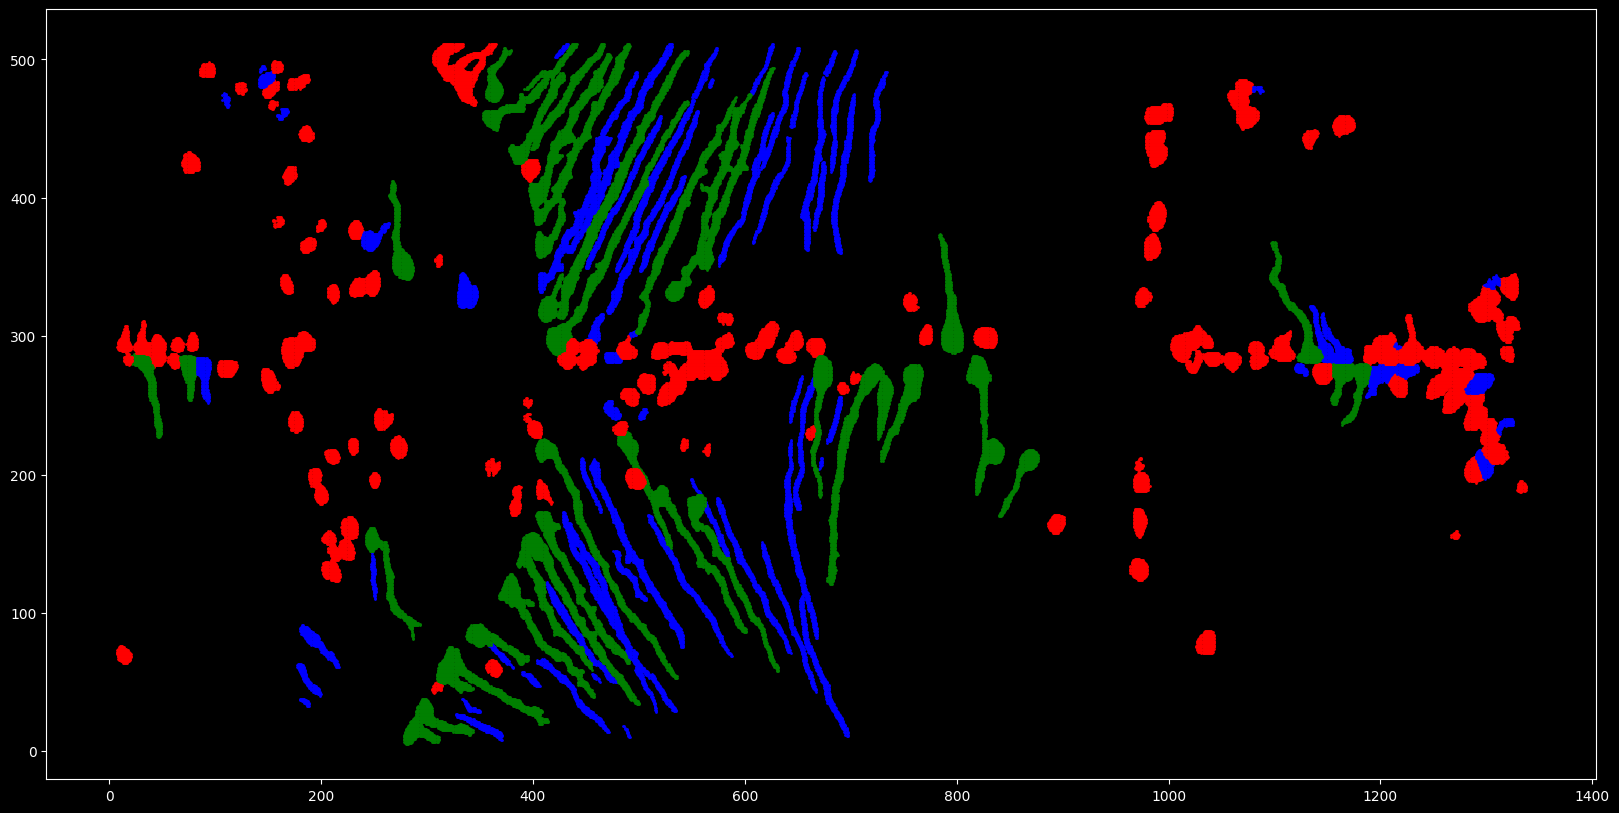

In [4]:
plt.figure(figsize=(20, 10))
visualize_classifications(masks=masks, classifications=classifications)
plt.show()

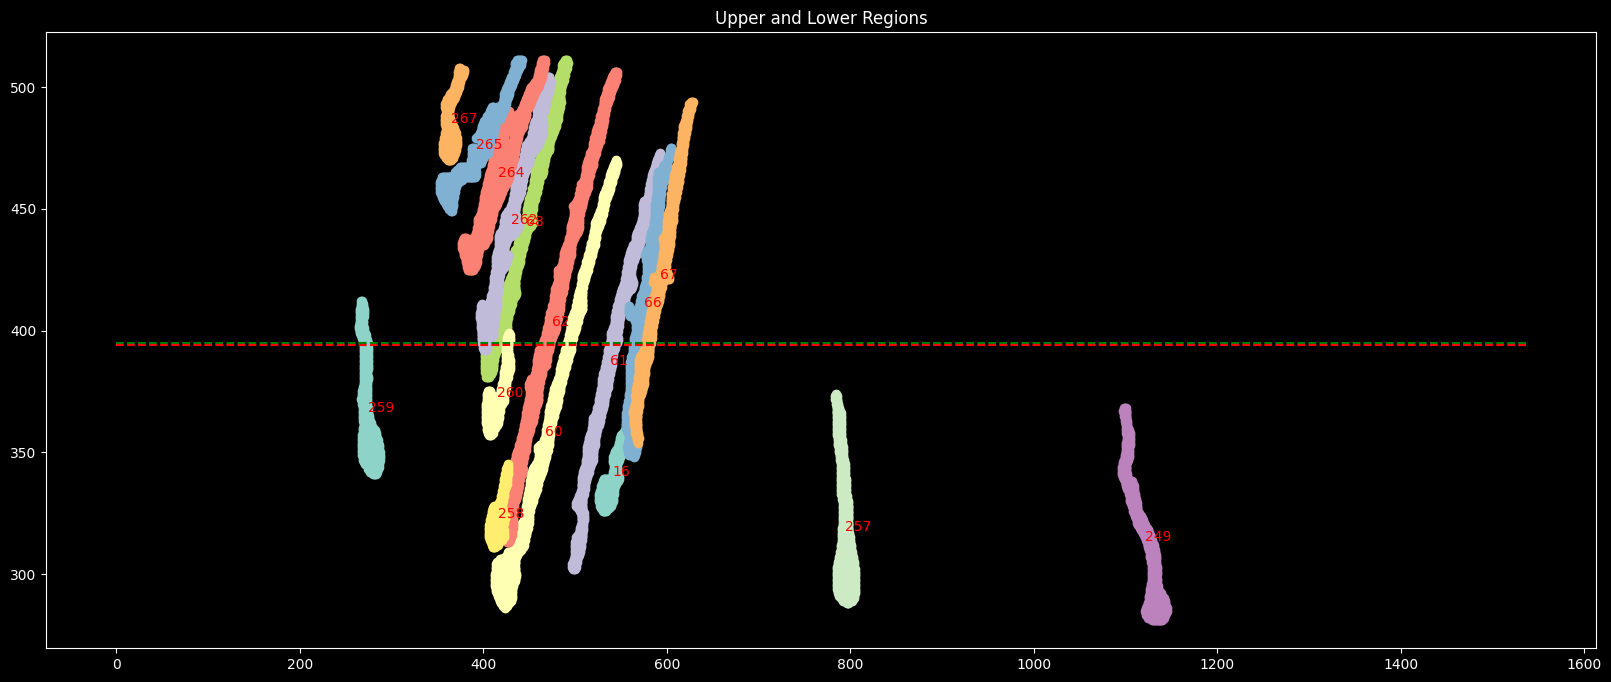

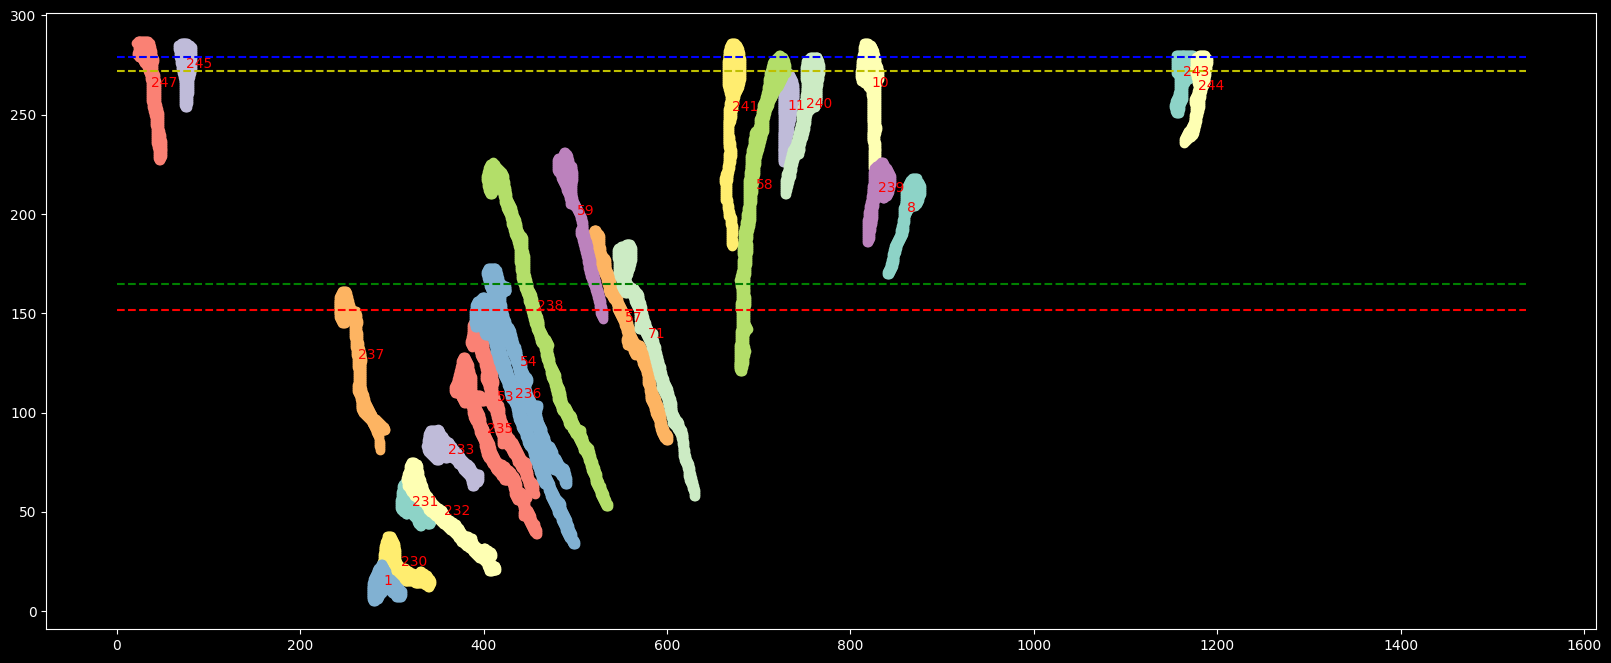

In [5]:
# Plot upper and lower regions

fig, ax = plt.subplots(figsize=(20, 8))

# Plot upper regions
means_upper = []
ax.set_title('Upper and Lower Regions')
for label in upper:
    region = np.where(masks == label)
    region = get_formated_region_coords(region)
    means_upper.append(np.mean(region, axis=0))
    ax.scatter(region[:, 0], region[:, 1])
    plt.text(np.mean(region[:, 0]), np.mean(region[:, 1]), str(label), fontsize=10, color='red')
median_upper = np.median(means_upper, axis=0)
mean_upper = np.mean(means_upper, axis=0)
plt.hlines(mean_upper[1], 0, masks.shape[1], colors='g', linestyles='dashed')
plt.hlines(median_upper[1], 0, masks.shape[1], colors='r', linestyles='dashed')

plt.show()


fig, ax = plt.subplots(figsize=(20, 8))
means_lower = []
# Plot lower regions
for label in lower:
    region = np.where(masks == label)
    region = get_formated_region_coords(region)
    means_lower.append(np.mean(region, axis=0))
    ax.scatter(region[:, 0], region[:, 1])
    plt.text(np.mean(region[:, 0]), np.mean(region[:, 1]), str(label), fontsize=10, color='red')
median_lower = np.median(means_lower, axis=0)
mean_lower = np.mean(means_lower, axis=0)
plt.hlines(median_lower[1], 0, masks.shape[1], colors='r', linestyles='dashed')
plt.hlines(mean_lower[1], 0, masks.shape[1], colors='g', linestyles='dashed')
cut_line = int((mean_upper[1] + mean_lower[1]) / 2)
cut_line_median = int((median_upper[1] + median_lower[1]) / 2)
plt.hlines(cut_line, 0, masks.shape[1], colors='b', linestyles='dashed')
plt.hlines(cut_line_median, 0, masks.shape[1], colors='y', linestyles='dashed')
plt.show()
# line_label, body = get_line(upper, masks,True)

# line = np.array([x[0] for x in line_label])
# line = np.array(line)
# sorted_indices = np.argsort(line[:, 0])
# line = line[sorted_indices]

# best_degree, best_r_score, best_mse, best_coefficients = best_fit_polynomial(line)

In [6]:
line_upper, body_upper = get_line(upper, masks,True,20)
line_lower, body_lower = get_line(lower, masks,False,20)

In [7]:

# from scipy.interpolate import splprep, splev
# from collections import defaultdict

upper_points = np.array([point[0] for point in line_upper])
lower_points = np.array([point[0] for point in line_lower])

# # Compute cumulative distance for parameter t
# def compute_cumulative_distance(points):
#     distances = np.sqrt(np.diff(points[:, 0])**2 + np.diff(points[:, 1])**2)
#     cumulative_distance = np.insert(np.cumsum(distances), 0, 0)
#     return cumulative_distance / cumulative_distance[-1]  # Normalize to [0,1]

# # t_upper = compute_cumulative_distance(upper_points)
# # t_lower = compute_cumulative_distance(lower_points)

# # Fit splines for parametric curves
# tck_upper, _ = splprep([upper_points[:, 0], upper_points[:, 1]], s=0,k=2)
# tck_lower, _ = splprep([lower_points[:, 0], lower_points[:, 1]], s=0,k=2)

# # Generate fitted points
# num_fit_points = 500
# t_fit_upper = np.linspace(0, 1, num_fit_points)
# t_fit_lower = np.linspace(0, 1, num_fit_points)
# x_fit_upper, y_fit_upper = splev(t_fit_upper, tck_upper)
# x_fit_lower, y_fit_lower = splev(t_fit_lower, tck_lower)

# # Define parametric functions
# def parametric_curve(t, tck):
#     return splev(t, tck)

# # Plotting
# plt.figure(figsize=(20, 10))

# # Plot Upper Body Points
# for i in range(len(line_upper)):
#     plt.scatter(body_upper[i][:, 0], body_upper[i][:, 1], color='lightblue', alpha=0.5)
# plt.scatter(upper_points[:, 0], upper_points[:, 1], color='blue', label='Upper Data Points')

# # Plot Fitted Upper Curve
# plt.plot(x_fit_upper, y_fit_upper, 'b-', label='Upper Spline Fit')

# # Plot Lower Body Points
# for i in range(len(line_lower)):
#     plt.scatter(body_lower[i][:, 0], body_lower[i][:, 1], color='lightcoral', alpha=0.5)
# plt.scatter(lower_points[:, 0], lower_points[:, 1], color='red', label='Lower Data Points')

# # Plot Fitted Lower Curve
# plt.plot(x_fit_lower, y_fit_lower, 'r-', label='Lower Spline Fit')

# plt.legend()
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.title('Data Points and Fitted Parametric Curves')
# plt.show()

# # Example usage of parametric functions
# t_new = 1  # Midpoint
# x_upper, y_upper = parametric_curve(t_new, tck_upper)
# x_lower, y_lower = parametric_curve(t_new, tck_lower)

# print(f"Upper Curve at t={t_new}: (x, y) = ({x_upper:.2f}, {y_upper:.2f})")
# print(f"Lower Curve at t={t_new}: (x, y) = ({x_lower:.2f}, {y_lower:.2f})")

No intersection found for process 12
No intersection found for process 135
No intersection found for process 171
No intersection found for process 198
No intersection found for process 216
No intersection found for process 219
No intersection found for process 223
No intersection found for process 226
No intersection found for process 228
No intersection found for process 246
No intersection found for process 250
No intersection found for process 3
No intersection found for process 4
No intersection found for process 94
No intersection found for process 107
No intersection found for process 125
No intersection found for process 234
No intersection found for process 242


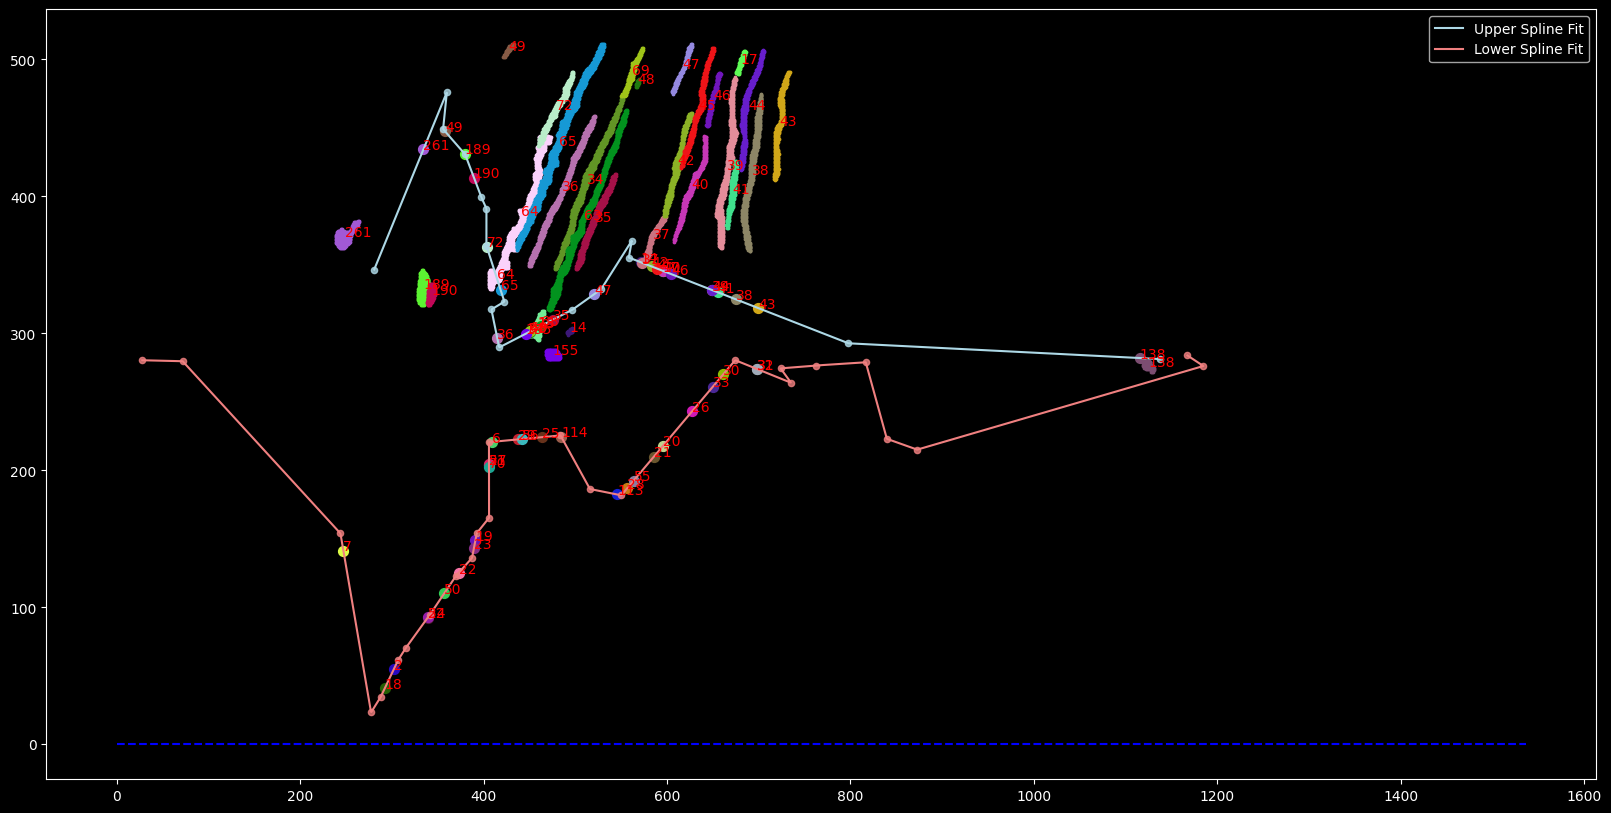

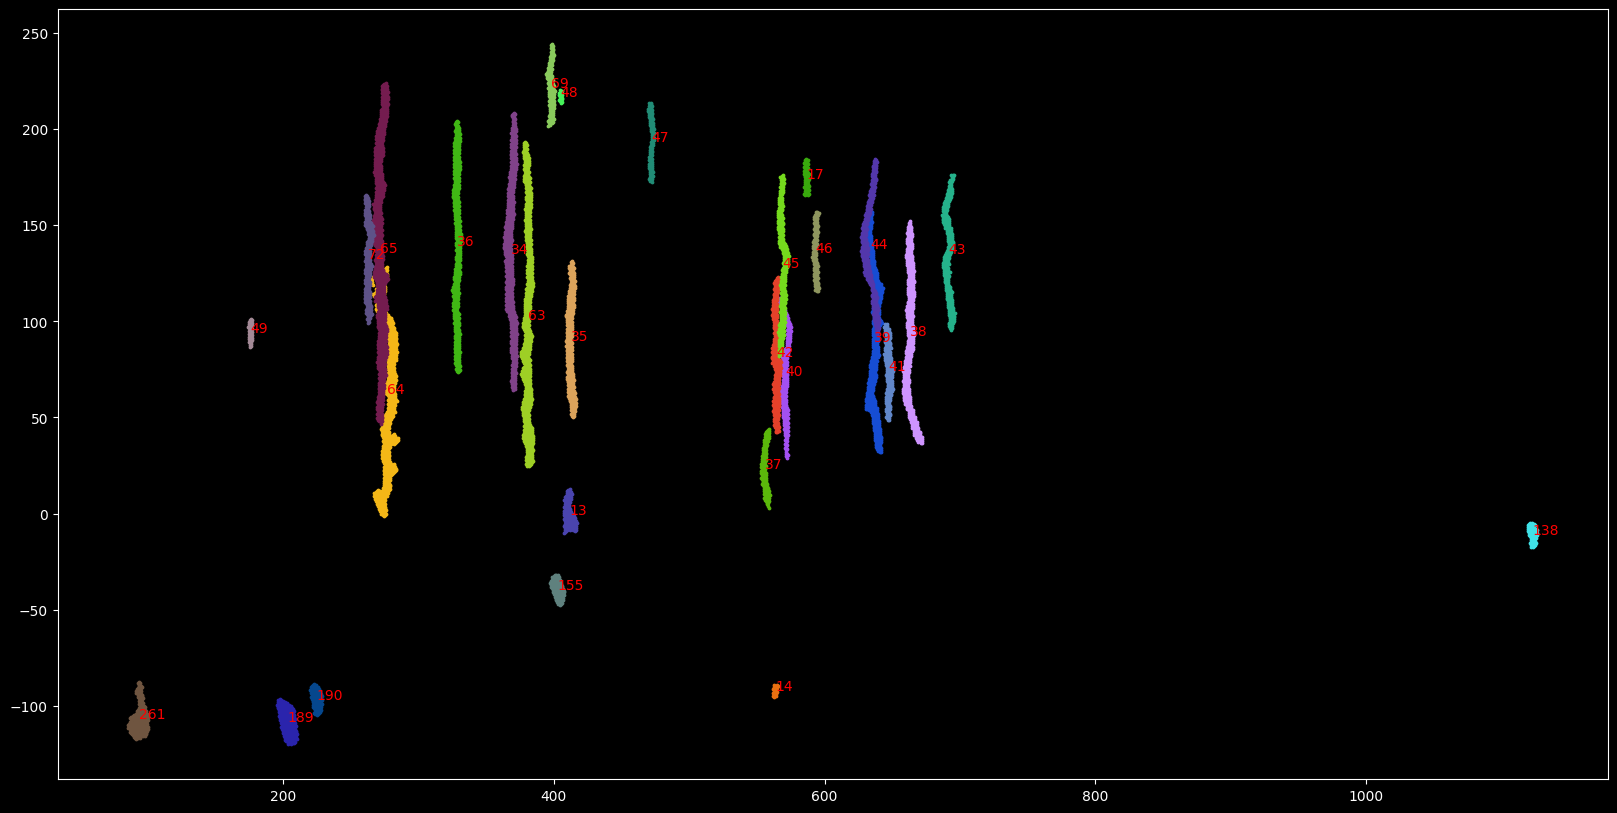

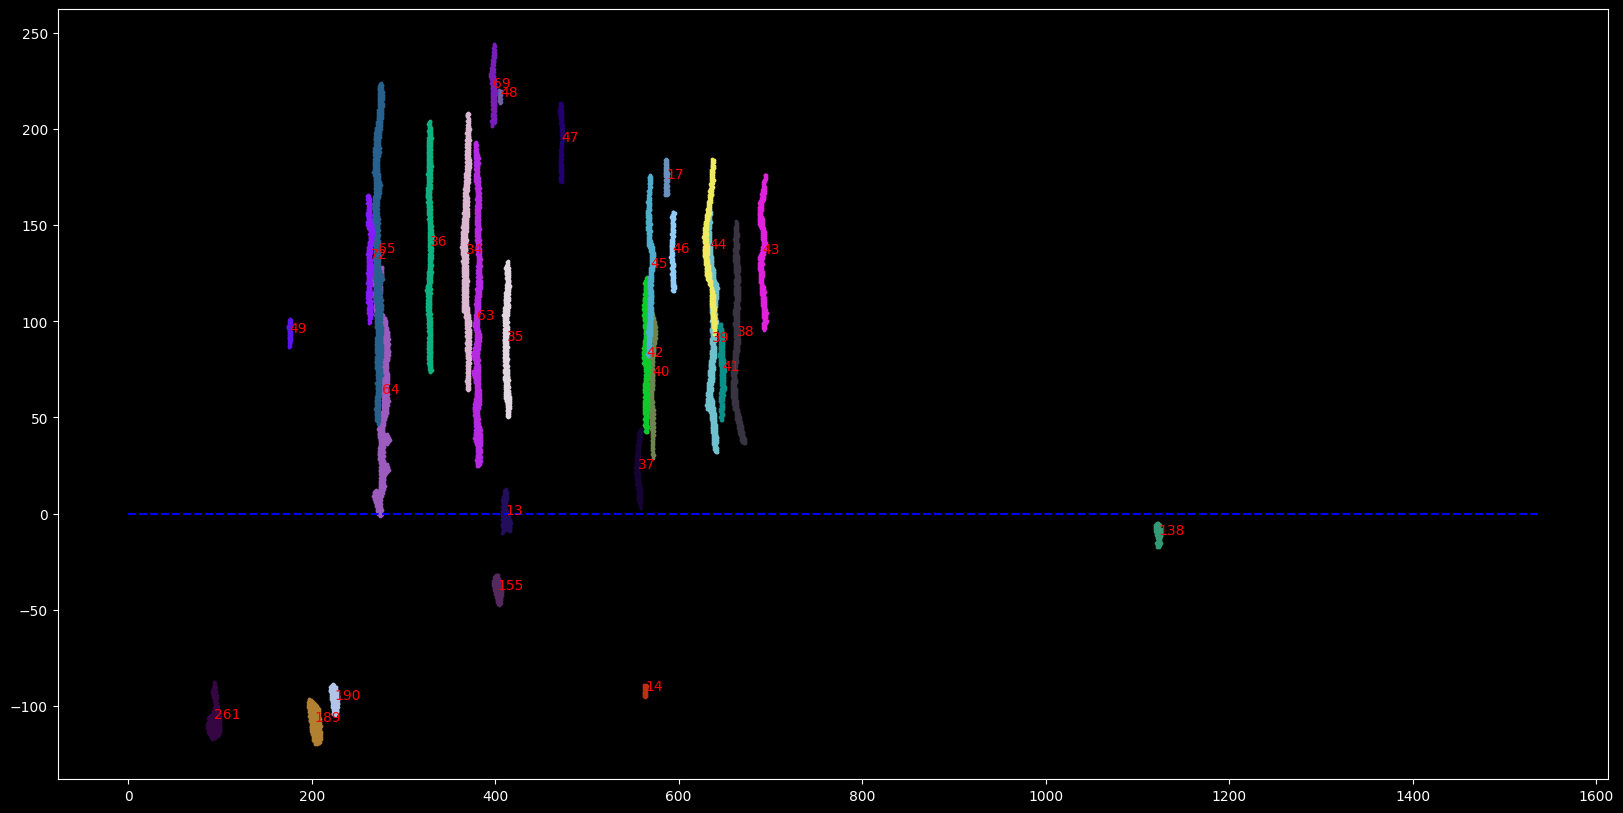

In [8]:
t_upper, tck_upper, x_fit_upper, y_fit_upper, total_length_upper = parametrize_curve(upper_points)
t_lower, tck_lower, x_fit_lower, y_fit_lower, total_length_lower = parametrize_curve(lower_points)

plt.figure(figsize=(20, 10))
processes_upper = processes["upper"]


intersection_list_upper = get_all_intersections(tck_upper,t_upper,ab_list_upper,upper=True)
intersection_list_lower = get_all_intersections(tck_lower,t_lower,ab_list_lower,upper=False)

for label, (t, x, y),d in intersection_list_upper:
    random_color = np.random.rand(3,)
    plt.scatter(x, y, color=random_color, s=50)

    coords = get_formated_region_coords(np.where(masks == label))
    plt.scatter(coords[:, 0], coords[:, 1], color=random_color, s=3)
    plt.text(np.mean(coords[:, 0]), np.mean(coords[:, 1]), str(label), fontsize=10, color='red')
    plt.text(x, y, str(label), fontsize=10, color='red')



for label, (t, x, y),d in intersection_list_lower:
    random_color = np.random.rand(3,)
    plt.scatter(x, y, color=random_color, s=50)
    plt.text(x, y, str(label), fontsize=10, color='red')
    

plot_parametrized_curve(upper_points, x_fit_upper, y_fit_upper ,color='lightblue', label='Upper Spline Fit')


plot_parametrized_curve(lower_points, x_fit_lower, y_fit_lower, color='lightcoral', label='Lower Spline Fit')
plt.hlines(0, 0, masks.shape[1], colors='b', linestyles='dashed')
plt.legend()
plt.show()

plt.figure(figsize=(20, 10))
for label, (t, x, y),d in intersection_list_upper:
    coords = get_formated_region_coords(np.where(masks == label))
    mean = np.mean(coords, axis=0)
    translattion = np.array([t,d]) - mean
    new_coords = coords + translattion
    pc,_,_ = get_pcs(new_coords)
    rotate_coords = rotate_region(pc,new_coords,True)
    r_color = np.random.rand(3,)
    plt.scatter(rotate_coords[:, 0], rotate_coords[:, 1], color=r_color,s=3)
    plt.text(np.mean(rotate_coords[:, 0]), np.mean(rotate_coords[:, 1]), str(label), fontsize=10, color='red')
plt.show()

aligned_process_upper = uniform_align(intersection_list_upper,masks,True)

plt.figure(figsize=(20, 10))
for label, coords in aligned_process_upper:
    r_color = np.random.rand(3,)
    plt.scatter(coords[:, 0], coords[:, 1], color=r_color,s=3)
    plt.text(np.mean(coords[:, 0]), np.mean(coords[:, 1]), str(label), fontsize=10, color='red')
plt.hlines(0, 0, masks.shape[1], colors='b', linestyles='dashed')
plt.show()

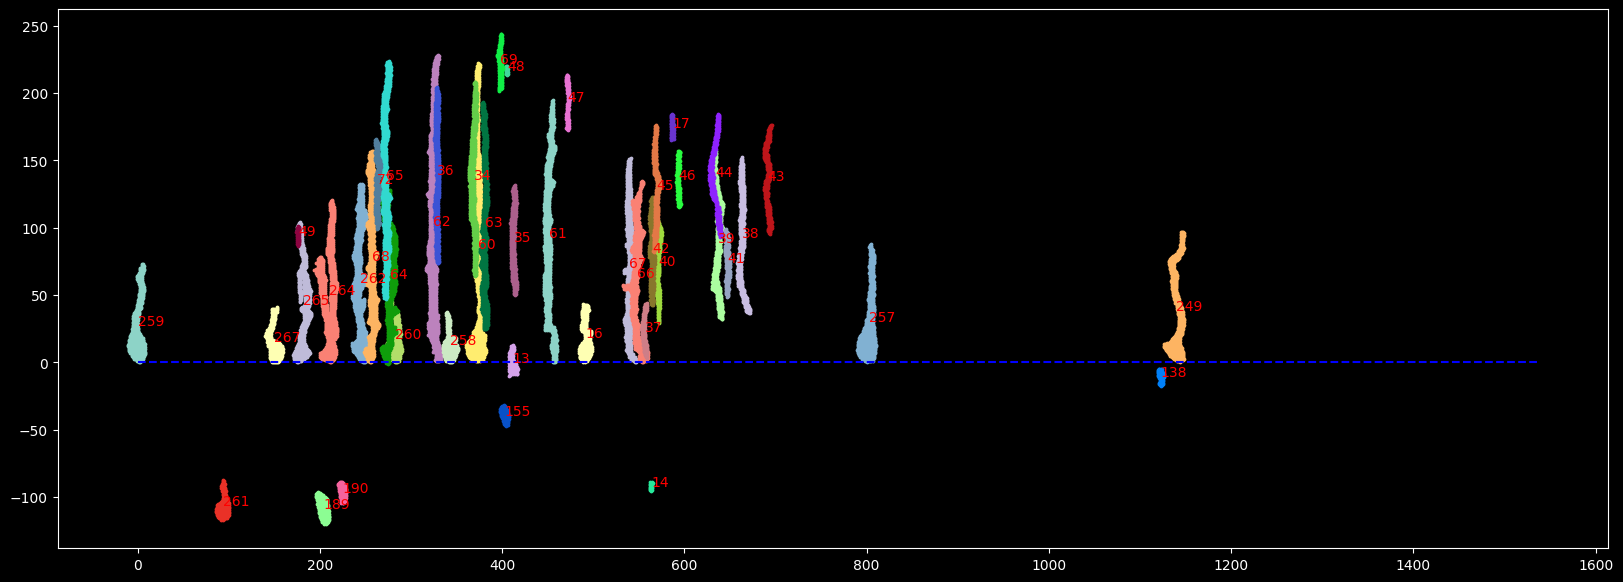

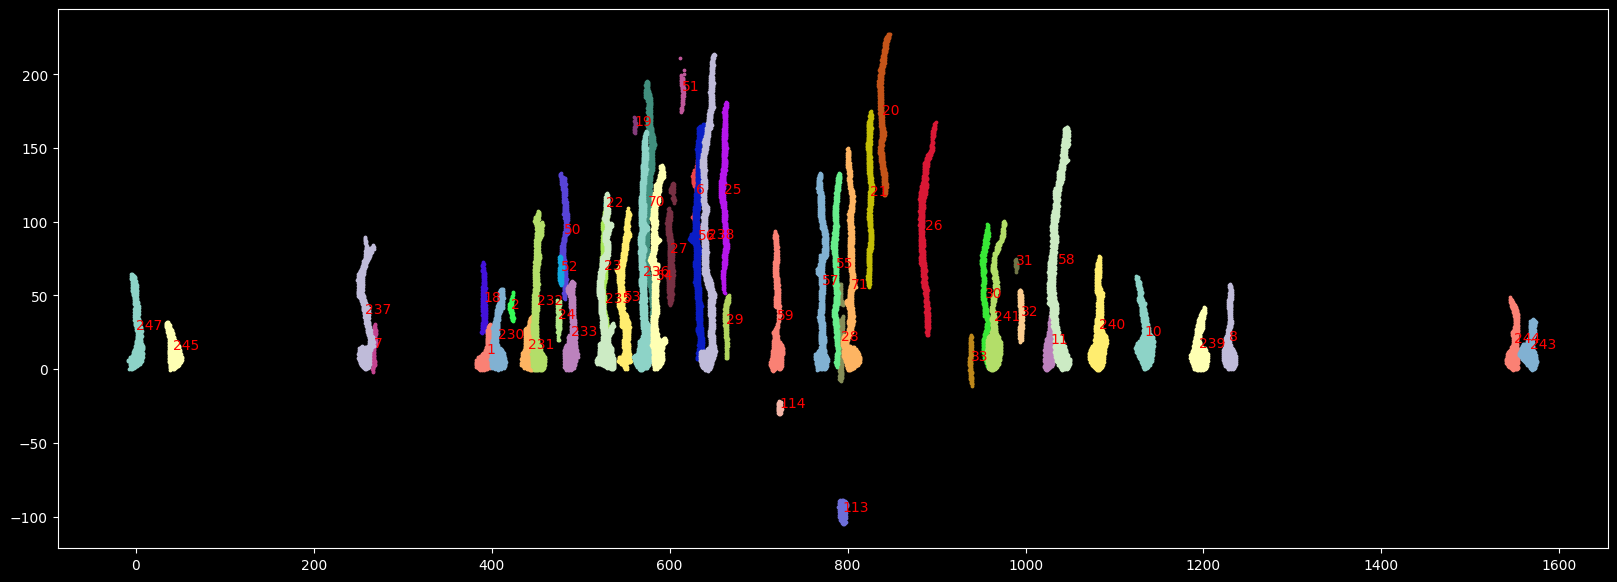

In [9]:
aligned_upper = align_regions(line_upper, masks, True)

aligned_lower = align_regions(line_lower, masks, False)

plt.figure(figsize=(20, 7))
i =0
for up in aligned_upper:
    plt.scatter(up[:, 0], up[:, 1],s=3)
    plt.text(np.mean(up[:, 0]), np.mean(up[:, 1]), str(line_upper[i][1]), fontsize=10, color='red')
    i+=1
# aligned_process_upper = uniform_align(intersection_list_upper,masks,True)

for label, coords in aligned_process_upper:
    r_color = np.random.rand(3,)
    plt.scatter(coords[:, 0], coords[:, 1], color=r_color,s=3)
    plt.text(np.mean(coords[:, 0]), np.mean(coords[:, 1]), str(label), fontsize=10, color='red')
plt.hlines(0, 0, masks.shape[1], colors='b', linestyles='dashed')
plt.show()

aligned_process_lower = uniform_align(intersection_list_lower,masks,False)


i = 0


plt.figure(figsize=(20, 7))
for label, coords in aligned_process_lower:
    r_color = np.random.rand(3,)
    plt.scatter(coords[:, 0], coords[:, 1], color=r_color,s=3)
    plt.text(np.mean(coords[:, 0]), np.mean(coords[:, 1]), str(label), fontsize=10, color='red')
    
for low in aligned_lower:
    plt.scatter(low[:, 0], low[:, 1],s=3)
    plt.text(np.mean(low[:, 0]), np.mean(low[:, 1]), str(line_lower[i][1]), fontsize=10, color='red')
    i+=1
plt.show()

In [10]:
# for region in aligned_upper:
#     subsemgents = subsegment_region_y_axis(region, 10)
#     visualize_subsegments(subsemgents)
# plt.show()

In [11]:
# path = r"C:\Users\javid.rezai\YaksiLab\subsegmented_masks_seg.npy"

# mask_file = np.load(path, allow_pickle=True).item()
# masks = mask_file['masks']

# labels = np.unique(masks)
# labels = labels[labels != 0]
# plt.figure(figsize=(20, 10))
# for label in labels:
#     region = np.where(masks == label)
#     region = get_formated_region_coords(region)
#     plt.scatter(region[:, 0], region[:, 1])
#     # plt.text(region[0][0], region[0][1], str(label),fontsize=8,c='r')

# plt.show()